In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### My Sql connection

In [ ]:
# import mysql.connector

# conn = mysql.connector.connect(
#     host='localhost',
#     user='root',
#     passwd='root',
#     database='e_master_card'
# )

In [78]:
import pymysql

conn = pymysql.connect(
    host='localhost',
    user='root',
    password='root',
    database='e_master_card'
)

In [79]:
df_cust = pd.read_sql('select * from customers',conn)
df_cust.head(5)

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2,City,Business Owner,358211,Married
1,2,Anjali Pandey,Female,47,City,Consultant,65172,Single
2,3,Aaryan Chauhan,Male,21,City,Freelancer,22378,Married
3,4,Rudra Bali,Male,24,Rural,Freelancer,33563,Married
4,5,Advait Malik,Male,48,City,Consultant,39406,Married


In [80]:
df_trans = pd.read_sql('select * from transactions',conn)
df_trans.head(5)

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking


In [81]:
df_cs = pd.read_sql('select * from credit_profiles',conn)
df_cs.head(5)

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0
3,4,504,0.336938,224.0,2.0,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0


#### after done importing the data from the mysql database close the connection

In [82]:
conn.close()

### get few info from the dataset

In [83]:
df_cust.columns

Index(['cust_id', 'name', 'gender', 'age', 'location', 'occupation',
       'annual_income', 'marital_status'],
      dtype='object')

In [84]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   cust_id         1000 non-null   int64 
 1   name            1000 non-null   object
 2   gender          1000 non-null   object
 3   age             1000 non-null   int64 
 4   location        1000 non-null   object
 5   occupation      1000 non-null   object
 6   annual_income   1000 non-null   int64 
 7   marital_status  1000 non-null   object
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [85]:
df_cust.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,36.405000,132439.799000
std,288.819436,15.666155,113706.313793
min,1.000000,1.000000,0.000000
25%,250.750000,26.000000,42229.750000
50%,500.500000,32.000000,107275.000000
75%,750.250000,46.000000,189687.500000
max,1000.000000,135.000000,449346.000000


### Checking the null values present in dataset and replaying them with the median

In [86]:
(df_cust==0).sum()

cust_id            0
name               0
gender             0
age                0
location           0
occupation         0
annual_income     50
marital_status     0
dtype: int64

## Anlayse Income Column

### Above since it is captured from db,"NA" are mentioned as '0'

In [87]:
df_cust.replace(0, np.nan, inplace=True)

In [88]:
df_cust.isna().sum()

cust_id            0
name               0
gender             0
age                0
location           0
occupation         0
annual_income     50
marital_status     0
dtype: int64

In [89]:
df_cust[df_cust.annual_income.isna()].head(4)

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
14,15,Sanjana Malik,Female,25,Rural,Artist,NaN,Married
82,83,Reyansh Mukherjee,Male,27,City,Freelancer,NaN,Single
97,98,Virat Puri,Male,47,Suburb,Business Owner,NaN,Married
102,103,Aarav Shah,Male,32,City,Data Scientist,NaN,Married


### Different ways to handle the null values
#### Option 1: Drop the null values 
#### Option 2: Replace the null with mean
#### Option 3: Replace the null with median [Overall median or w.r.to occupation]--->This is best suited here

In [90]:
occupation_wise = df_cust.groupby('occupation')['annual_income'].median()
occupation_wise

occupation
Accountant              65265.0
Artist                  45794.0
Business Owner         261191.5
Consultant              58017.0
Data Scientist         135759.0
Freelancer              46759.0
Fullstack Developer     76774.0
Name: annual_income, dtype: float64

In [91]:
medians = df_cust.groupby('occupation')['annual_income'].transform('median')
df_cust['annual_income'] = df_cust['annual_income'].fillna(medians)


In [92]:
df_cust.isna().sum()

cust_id           0
name              0
gender            0
age               0
location          0
occupation        0
annual_income     0
marital_status    0
dtype: int64

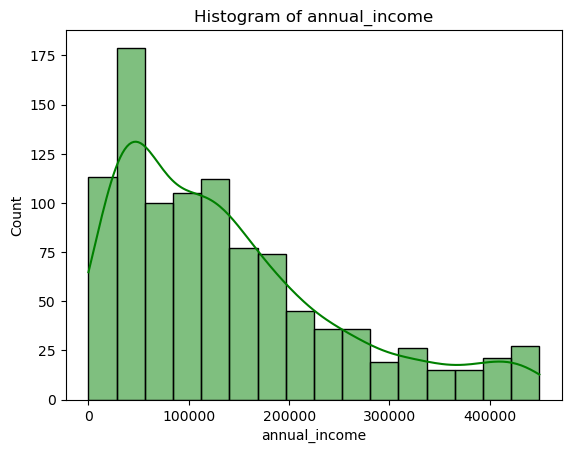

In [93]:
plt.figure()
sns.histplot(df_cust['annual_income'], kde=True, color='green', label='Data')
plt.title('Histogram of annual_income')
plt.show()

### Removal of Outliers 

#### method using lower and upper bound

In [94]:
df_cust.annual_income.mean(),df_cust.annual_income.std()

(138916.7655, 110969.40864336627)

In [95]:
lower=df_cust.annual_income.mean()- 3*df_cust.annual_income.std()
upper=df_cust.annual_income.mean() + 3*df_cust.annual_income.std()
lower,upper

(-193991.46043009878, 471824.9914300988)

### we can follow the above method to find outliers but as per the dataset anything less than 100 might be an error

In [96]:
df_cust[df_cust['annual_income']<100]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
31,32,Veer Mistry,Male,50,City,Business Owner,50.0,Married
262,263,Vivaan Tandon,Male,53,Suburb,Business Owner,50.0,Married
316,317,Yuvraj Saxena,Male,47,City,Consultant,50.0,Married
333,334,Avani Khanna,Female,29,City,Data Scientist,50.0,Married
340,341,Priya Sinha,Female,33,Rural,Fullstack Developer,50.0,Married
543,544,Advait Batra,Male,54,City,Consultant,2.0,Married
592,593,Priya Gandhi,Female,32,City,Business Owner,50.0,Married
633,634,Rudra Mehtani,Male,26,City,Data Scientist,2.0,Married
686,687,Vihaan Jaiswal,Male,40,City,Business Owner,2.0,Married
696,697,Ishan Negi,Male,47,City,Consultant,20.0,Married


In [97]:
for index, row in df_cust.iterrows():
    if row["annual_income"] < 100:
        occupation = df_cust.at[index, "occupation"]
        df_cust.at[index, "annual_income"] = occupation_wise[occupation]

In [98]:
df_cust[df_cust['annual_income']<100]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status


In [99]:
df_cust.loc[[31,316]]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
31,32,Veer Mistry,Male,50,City,Business Owner,261191.5,Married
316,317,Yuvraj Saxena,Male,47,City,Consultant,58017.0,Married


### Different Visualization

In [100]:
occupation_wise_avg = df_cust.groupby('occupation')['annual_income'].mean()
occupation_wise_avg

occupation
Accountant              64123.562500
Artist                  45309.236842
Business Owner         268447.368512
Consultant              60703.154639
Data Scientist         137021.266304
Freelancer              76327.508772
Fullstack Developer     78727.972973
Name: annual_income, dtype: float64

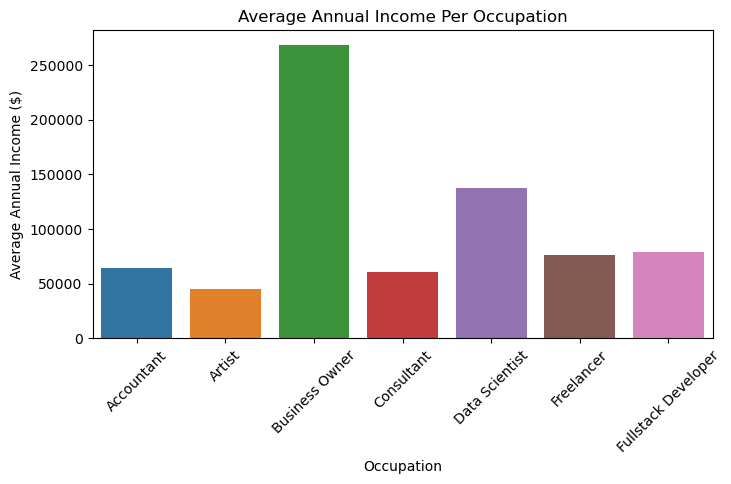

In [101]:
plt.figure(figsize=(8,4))
sns.barplot(x=occupation_wise_avg.index, y=occupation_wise_avg.values, palette='tab10')
plt.xticks(rotation=45)
plt.title('Average Annual Income Per Occupation')
plt.xlabel('Occupation')
plt.ylabel('Average Annual Income ($)')
plt.show()

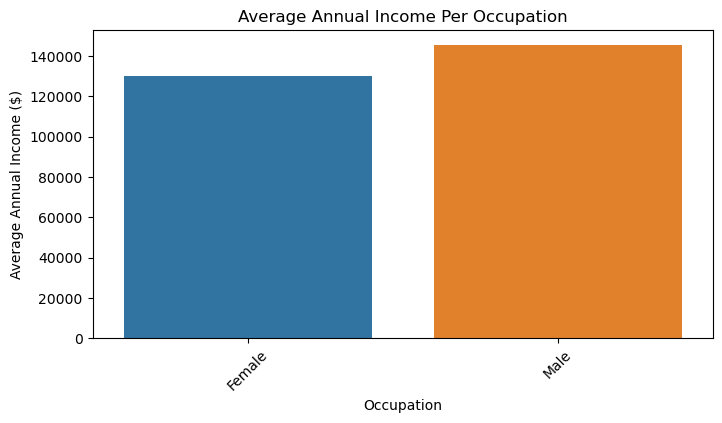

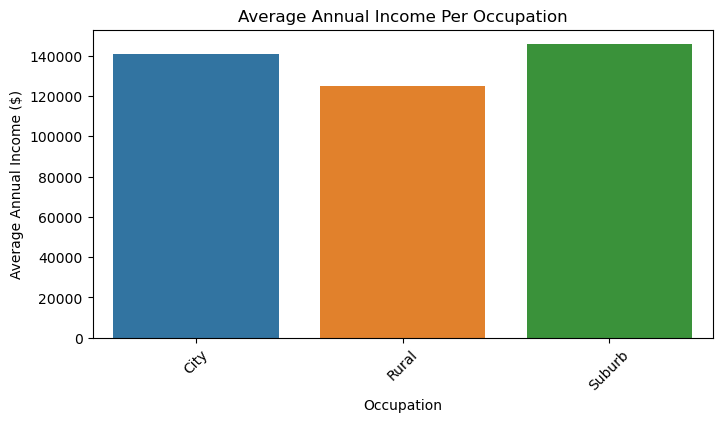

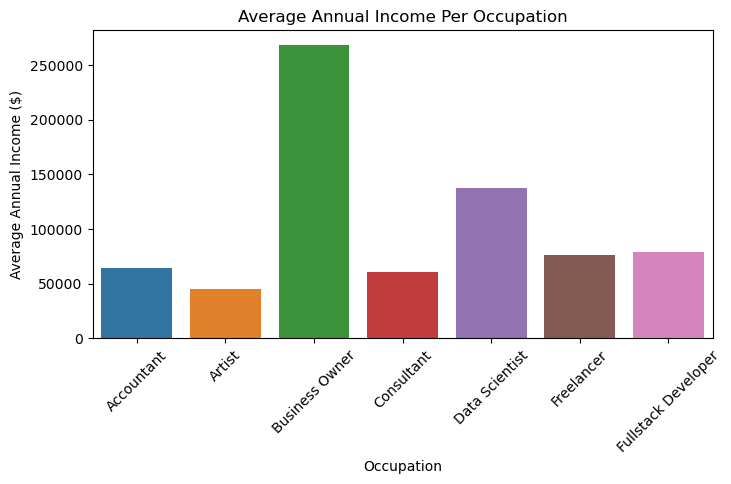

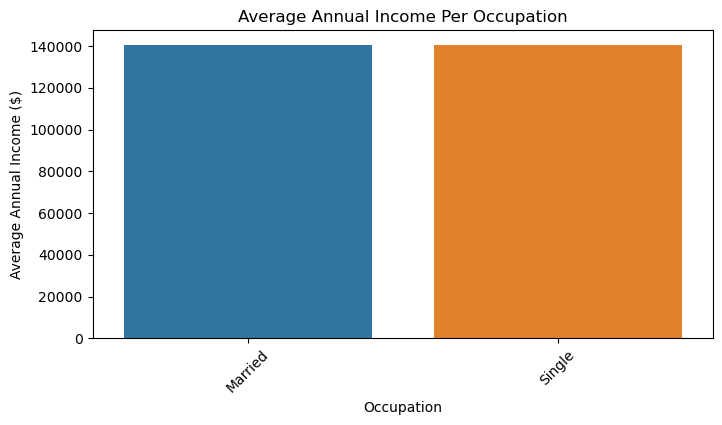

In [102]:
categories=['gender', 'location', 'occupation', 'marital_status']

for col in categories:
    plt.figure(figsize=(8,4))
    grpby = df_cust.groupby(col)['annual_income'].mean()
    sns.barplot(x=grpby.index, y=grpby.values, palette='tab10')
    plt.xticks(rotation=45)
    plt.title('Average Annual Income Per Occupation')
    plt.xlabel('Occupation')
    plt.ylabel('Average Annual Income ($)')
    plt.show()

## Analyse Age Column

#### Handling the null values

In [103]:
df_cust['age'].isna().sum()

0

In [104]:
df_cust.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,36.405000,140483.548500
std,288.819436,15.666155,110463.002934
min,1.000000,1.000000,5175.000000
25%,250.750000,26.000000,49620.500000
50%,500.500000,32.000000,115328.000000
75%,750.250000,46.000000,195514.250000
max,1000.000000,135.000000,449346.000000


#### from above we can see the age max is 135 which is not normal in our case like wise min 1 is also not invalid

### Removal of outlier

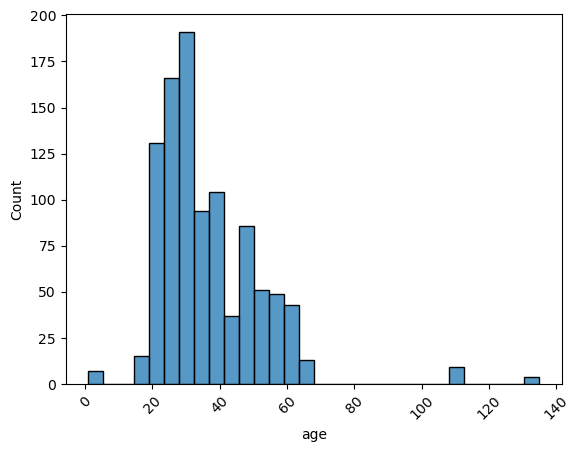

In [105]:
sns.histplot(df_cust.age,bins=30)
plt.xticks(rotation=45)
plt.show()

#### as u can see in the above histogram values below 20 and values above 100 are clearly an outlier

In [106]:
outliers=df_cust[(df_cust.age<15)|(df_cust.age>80)]
outliers

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2,City,Business Owner,358211.0,Married
41,42,Aaryan Shah,Male,110,City,Artist,7621.0,Married
165,166,Sia Dutta,Female,1,City,Freelancer,39721.0,Single
174,175,Rohan Sharma,Male,110,City,Freelancer,23723.0,Married
222,223,Arjun Batra,Male,110,Suburb,Freelancer,210987.0,Married
277,278,Aarav Tandon,Male,110,City,Consultant,96522.0,Single
295,296,Ayush Pandey,Male,1,Rural,Accountant,55254.0,Married
325,326,Virat Goel,Male,110,City,Accountant,61021.0,Single
610,611,Rehan Verma,Male,135,Rural,Business Owner,444776.0,Married
692,693,Dhruv Jha,Male,1,City,Business Owner,83045.0,Married


In [107]:
occupation_wise_age = df_cust.groupby('occupation')['age'].median()
occupation_wise_age

occupation
Accountant             31.5
Artist                 26.0
Business Owner         51.0
Consultant             46.0
Data Scientist         32.0
Freelancer             24.0
Fullstack Developer    27.5
Name: age, dtype: float64

In [108]:
for index,row in outliers.iterrows():
     occupation = df_cust.at[index, 'occupation']
     df_cust.at[index, 'age'] = occupation_wise_age[occupation]

In [109]:
outliers=df_cust[(df_cust.age<15)|(df_cust.age>80)]
outliers

,cust_id,name,gender,age,location,occupation,annual_income,marital_status


In [110]:
df_cust.age.describe()

count    1000.000000
mean       35.541500
std        12.276634
min        18.000000
25%        26.000000
50%        32.000000
75%        44.250000
max        64.000000
Name: age, dtype: float64

In [111]:
# Define the bin edges and labels
bin_edges = [17, 25, 48, 65]
bin_labels = ['18-25', '26-48', '49-65']

df_cust['age_group']=pd.cut(df_cust.age, bins=bin_edges, labels=bin_labels)

In [112]:
df_cust.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group
0,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65
1,2,Anjali Pandey,Female,47.0,City,Consultant,65172.0,Single,26-48
2,3,Aaryan Chauhan,Male,21.0,City,Freelancer,22378.0,Married,18-25
3,4,Rudra Bali,Male,24.0,Rural,Freelancer,33563.0,Married,18-25
4,5,Advait Malik,Male,48.0,City,Consultant,39406.0,Married,26-48


In [113]:
age_grp=df_cust['age_group'].value_counts(normalize=True)*100
age_grp

age_group
26-48    56.7
18-25    24.6
49-65    18.7
Name: proportion, dtype: float64

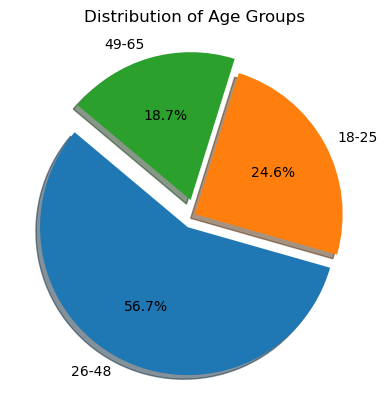

In [114]:
plt.pie(age_grp, 
        labels=age_grp.index,
        explode=(0.1,0,0.1), 
        autopct='%1.1f%%', 
        shadow=True,
        startangle=140
    )
plt.title('Distribution of Age Groups')
plt.show()

#### from the above graph we can infer that 57% are in the age grp 26-48

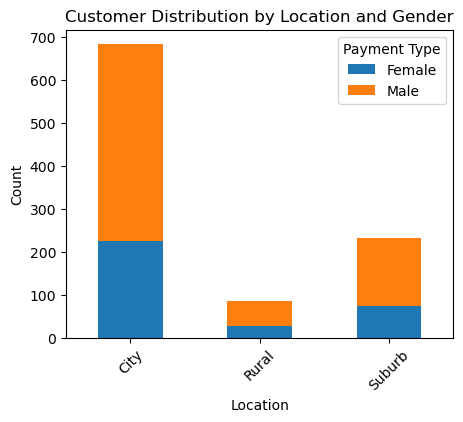

In [115]:
customer_location_gender = df_cust.groupby(['location', 'gender']).size().unstack(fill_value=0)
customer_location_gender.plot(kind='bar', stacked=True, figsize=(5, 4))
plt.xlabel('Location')
plt.ylabel('Count')
plt.title('Customer Distribution by Location and Gender')
plt.legend(title='Payment Type')
plt.xticks(rotation=45)

plt.show()

## Explore Credit Score

#### Handling duplicate values

In [116]:
df_cs.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0
3,4,504,0.336938,224.0,2.0,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0


In [117]:
df_cs.cust_id.nunique()

1000

In [118]:
df_cs[df_cs.duplicated('cust_id',keep=False)]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
516,517,308,NaN,NaN,NaN,NaN
517,517,308,0.113860,33.0,3.0,500.0
569,569,344,NaN,NaN,NaN,NaN
570,569,344,0.112599,37.0,0.0,500.0
607,606,734,NaN,NaN,NaN,NaN
608,606,734,0.193418,4392.0,1.0,40000.0
664,662,442,NaN,NaN,NaN,NaN
665,662,442,0.856039,266.0,2.0,500.0


In [119]:
df_cs_clean_1 = df_cs.drop_duplicates('cust_id',keep='first')
df_cs_clean_1

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0
3,4,504,0.336938,224.0,2.0,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0
...,...,...,...,...,...,...
999,996,564,0.702963,688.0,2.0,1250.0
1000,997,774,0.465462,17139.0,0.0,60000.0
1001,998,529,0.585856,386.0,3.0,1000.0
1002,999,725,0.249670,6973.0,2.0,40000.0


In [120]:
df_cs_clean_1[df_cs_clean_1.duplicated('cust_id',keep=False)]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit


#### Handling null Values

In [121]:
df_cs_clean_1.isna().sum()

cust_id                            0
credit_score                       0
credit_utilisation                 4
outstanding_debt                   4
credit_inquiries_last_6_months     4
credit_limit                      69
dtype: int64

In [122]:
df_cs_clean_1[df_cs_clean_1['credit_limit'].isna()]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
10,11,679,0.557450,9187.0,2.0,NaN
35,36,790,0.112535,4261.0,1.0,NaN
37,38,514,0.296971,238.0,2.0,NaN
45,46,761,0.596041,24234.0,2.0,NaN
64,65,734,0.473715,13631.0,0.0,NaN
...,...,...,...,...,...,...
912,909,479,0.487555,320.0,3.0,NaN
931,928,311,0.832244,316.0,2.0,NaN
948,945,526,0.272734,227.0,1.0,NaN
954,951,513,0.175914,131.0,3.0,NaN


In [123]:
df_cs_clean_1['credit_limit'].value_counts()

credit_limit
500.0      226
60000.0    186
40000.0    136
1500.0     100
1000.0      90
750.0       76
1250.0      75
20000.0     42
Name: count, dtype: int64

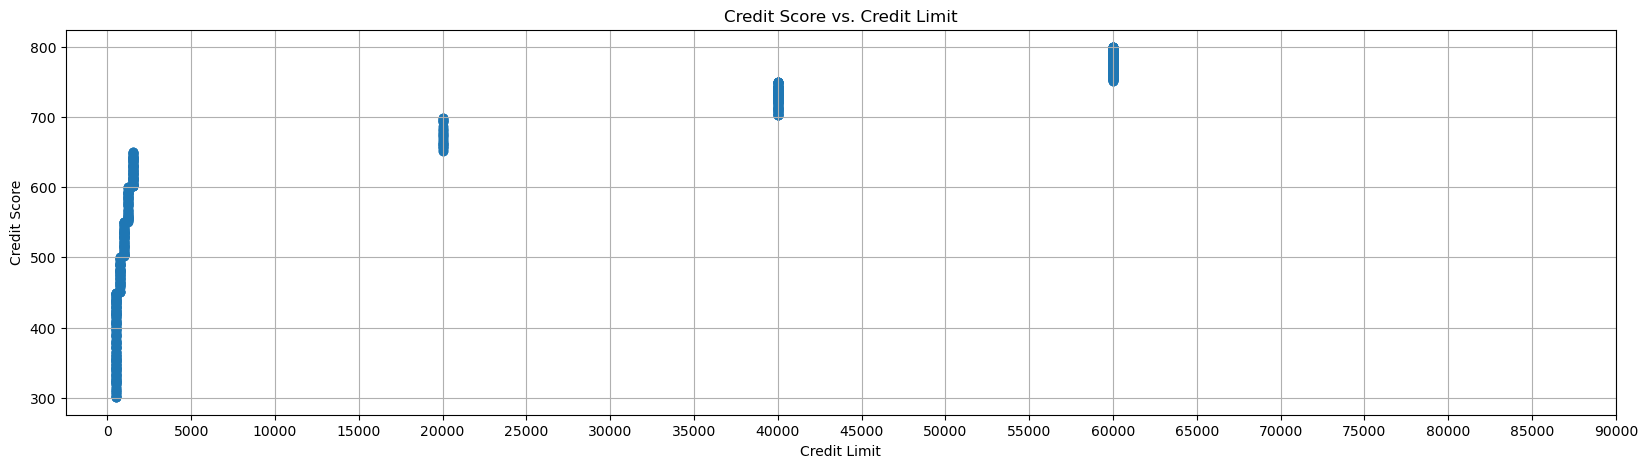

In [124]:
plt.figure(figsize=(20, 5))
plt.scatter(x=df_cs_clean_1['credit_limit'],y=df_cs_clean_1['credit_score'])
plt.title('Credit Score vs. Credit Limit')
plt.xlabel('Credit Limit')
plt.ylabel('Credit Score')
plt.xticks(range(0, 90001, 5000))
plt.grid(True)
plt.show()

In [125]:
bin_ranges = [300, 450, 500, 550, 600, 650, 700, 750, 800]
bin_labels = [f'{start}-{end-1}' for start, end in zip(bin_ranges, bin_ranges[1:])]

df_cs_clean_1['credit_score_range'] = pd.cut(df_cs_clean_1['credit_score'], bins=bin_ranges,
                                             labels=bin_labels, include_lowest=True, right=False)

In [126]:
df_cs_clean_1.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
0,1,749,0.585171,19571.0,0.0,40000.0,700-749
1,2,587,0.107928,161644.0,2.0,1250.0,550-599
2,3,544,0.854807,513.0,4.0,1000.0,500-549
3,4,504,0.336938,224.0,2.0,1000.0,500-549
4,5,708,0.586151,18090.0,2.0,40000.0,700-749


In [127]:
df_cs_clean_1[['credit_score','credit_score_range', 'credit_limit']].head(3)

,credit_score,credit_score_range,credit_limit
0,749,700-749,40000.0
1,587,550-599,1250.0
2,544,500-549,1000.0


In [128]:
df_cs_clean_1[df_cs_clean_1['credit_score_range']=='750-799']

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
21,22,785,0.897089,36083.0,3.0,60000.0,750-799
25,26,758,0.250811,190838.0,2.0,60000.0,750-799
26,27,766,0.830908,31344.0,3.0,60000.0,750-799
29,30,798,0.222597,7238.0,2.0,60000.0,750-799
31,32,768,0.747793,35109.0,2.0,60000.0,750-799
...,...,...,...,...,...,...,...
988,985,770,0.628088,33405.0,2.0,60000.0,750-799
993,990,772,0.259958,11937.0,2.0,60000.0,750-799
996,993,782,0.477170,20305.0,2.0,60000.0,750-799
1000,997,774,0.465462,17139.0,0.0,60000.0,750-799


#### Above you can see that most of them have credit limit 60000 so we use the mode to handle the null values

In [129]:
mode_df = df_cs_clean_1.groupby('credit_score_range')['credit_limit'].agg(lambda x: x.mode().iloc[0]).reset_index()
mode_df

,credit_score_range,credit_limit
0,300-449,500.0
1,450-499,750.0
2,500-549,1000.0
3,550-599,1250.0
4,600-649,1500.0
5,650-699,20000.0
6,700-749,40000.0
7,750-799,60000.0


In [130]:
df_cs_clean_2= pd.merge(df_cs_clean_1,mode_df,on='credit_score_range',suffixes=('','_mode'))
df_cs_clean_2

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
0,1,749,0.585171,19571.0,0.0,40000.0,700-749,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0,550-599,1250.0
2,3,544,0.854807,513.0,4.0,1000.0,500-549,1000.0
3,4,504,0.336938,224.0,2.0,1000.0,500-549,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0,700-749,40000.0
...,...,...,...,...,...,...,...,...
995,996,564,0.702963,688.0,2.0,1250.0,550-599,1250.0
996,997,774,0.465462,17139.0,0.0,60000.0,750-799,60000.0
997,998,529,0.585856,386.0,3.0,1000.0,500-549,1000.0
998,999,725,0.249670,6973.0,2.0,40000.0,700-749,40000.0


In [131]:
df_cs_clean_2[df_cs_clean_2.credit_limit.isnull()]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
10,11,679,0.557450,9187.0,2.0,NaN,650-699,20000.0
35,36,790,0.112535,4261.0,1.0,NaN,750-799,60000.0
37,38,514,0.296971,238.0,2.0,NaN,500-549,1000.0
45,46,761,0.596041,24234.0,2.0,NaN,750-799,60000.0
64,65,734,0.473715,13631.0,0.0,NaN,700-749,40000.0
...,...,...,...,...,...,...,...,...
908,909,479,0.487555,320.0,3.0,NaN,450-499,750.0
927,928,311,0.832244,316.0,2.0,NaN,300-449,500.0
944,945,526,0.272734,227.0,1.0,NaN,500-549,1000.0
950,951,513,0.175914,131.0,3.0,NaN,500-549,1000.0


In [132]:
df_cs_clean_3 = df_cs_clean_2.copy()
df_cs_clean_3['credit_limit'].fillna(df_cs_clean_3['credit_limit_mode'],inplace=True)


In [133]:
df_cs_clean_3.isnull().sum()

cust_id                           0
credit_score                      0
credit_utilisation                4
outstanding_debt                  4
credit_inquiries_last_6_months    4
credit_limit                      0
credit_score_range                0
credit_limit_mode                 0
dtype: int64

In [134]:
df_cs_clean_3[df_cs_clean_3.cust_id==117]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
116,117,372,0.604427,252.0,4.0,500.0,300-449,500.0


### Handling outliers

In [135]:
df_cs_clean_3.describe()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_limit_mode
count,1000.000000,1000.000000,996.000000,996.000000,996.000000,1000.00000,1000.000000
mean,500.500000,589.182000,0.499673,9717.739960,1.956827,19733.75000,19912.500000
std,288.819436,152.284929,0.232488,25300.570253,1.415330,24717.43818,24840.914633
min,1.000000,300.000000,0.103761,37.000000,0.000000,500.00000,500.000000
25%,250.750000,460.000000,0.294846,221.750000,1.000000,750.00000,750.000000
50%,500.500000,601.500000,0.487782,554.000000,2.000000,1500.00000,1500.000000
75%,750.250000,738.000000,0.697829,11892.750000,3.000000,40000.00000,40000.000000
max,1000.000000,799.000000,0.899648,209901.000000,4.000000,60000.00000,60000.000000


#### when we observer the min and max for above we can clearly see that the outstanding debt is having an outlier.
#### if we look into credit limit 60k is the max and in the outstanding debt its 2L which is contracdicting here as outstanding debt can be less are equal to credit limit

Text(0.5, 1.0, 'Box plot for outstanding debt')

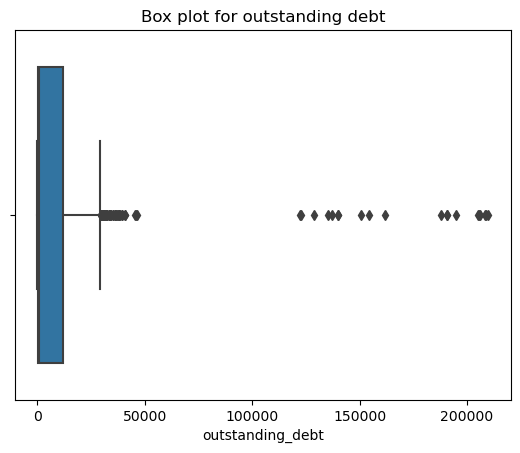

In [136]:
sns.boxplot(x=df_cs_clean_3['outstanding_debt'])
plt.title('Box plot for outstanding debt')

In [137]:
df_cs_clean_3[df_cs_clean_3['outstanding_debt']>df_cs_clean_3['credit_limit']]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
1,2,587,0.107928,161644.0,2.0,1250.0,550-599,1250.0
19,20,647,0.439132,205014.0,3.0,1500.0,600-649,1500.0
25,26,758,0.250811,190838.0,2.0,60000.0,750-799,60000.0
38,39,734,0.573023,122758.0,3.0,40000.0,700-749,40000.0
93,94,737,0.739948,137058.0,2.0,40000.0,700-749,40000.0
204,205,303,0.364360,187849.0,0.0,500.0,300-449,500.0
271,272,703,0.446886,154568.0,1.0,40000.0,700-749,40000.0
301,302,722,0.608076,122402.0,4.0,40000.0,700-749,40000.0
330,331,799,0.363420,208898.0,4.0,60000.0,750-799,60000.0
350,351,320,0.285081,150860.0,0.0,500.0,300-449,500.0


In [138]:
df_cs_clean_3.loc[df_cs_clean_3['outstanding_debt']>df_cs_clean_3['credit_limit'],'outstanding_debt']

1      161644.0
19     205014.0
25     190838.0
38     122758.0
93     137058.0
204    187849.0
271    154568.0
301    122402.0
330    208898.0
350    150860.0
446    206191.0
544    135112.0
636    140063.0
646    128818.0
698    190717.0
723    140008.0
725    205404.0
730    209901.0
766    195004.0
862    208406.0
Name: outstanding_debt, dtype: float64

In [139]:
df_cs_clean_3.loc[df_cs_clean_3['outstanding_debt'] > df_cs_clean_3['credit_limit'], 'outstanding_debt'] = df_cs_clean_3['credit_limit']

In [140]:
df_cs_clean_3.loc[[1,66]]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
1,2,587,0.107928,1250.0,2.0,1250.0,550-599,1250.0
66,67,429,0.229638,69.0,4.0,500.0,300-449,500.0


In [141]:
df_cs_clean_3.describe()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_limit_mode
count,1000.000000,1000.000000,996.000000,996.000000,996.000000,1000.00000,1000.000000
mean,500.500000,589.182000,0.499673,6872.847390,1.956827,19733.75000,19912.500000
std,288.819436,152.284929,0.232488,10698.220935,1.415330,24717.43818,24840.914633
min,1.000000,300.000000,0.103761,37.000000,0.000000,500.00000,500.000000
25%,250.750000,460.000000,0.294846,221.750000,1.000000,750.00000,750.000000
50%,500.500000,601.500000,0.487782,544.000000,2.000000,1500.00000,1500.000000
75%,750.250000,738.000000,0.697829,11018.000000,3.000000,40000.00000,40000.000000
max,1000.000000,799.000000,0.899648,60000.000000,4.000000,60000.00000,60000.000000


### Visualization of correlation in credit score table

In [142]:
df_cs_clean_3.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
0,1,749,0.585171,19571.0,0.0,40000.0,700-749,40000.0
1,2,587,0.107928,1250.0,2.0,1250.0,550-599,1250.0
2,3,544,0.854807,513.0,4.0,1000.0,500-549,1000.0
3,4,504,0.336938,224.0,2.0,1000.0,500-549,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0,700-749,40000.0


In [143]:
df_cust.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group
0,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65
1,2,Anjali Pandey,Female,47.0,City,Consultant,65172.0,Single,26-48
2,3,Aaryan Chauhan,Male,21.0,City,Freelancer,22378.0,Married,18-25
3,4,Rudra Bali,Male,24.0,Rural,Freelancer,33563.0,Married,18-25
4,5,Advait Malik,Male,48.0,City,Consultant,39406.0,Married,26-48


In [144]:
df_merged= df_cust.merge(df_cs_clean_3,how="inner",on='cust_id')
df_merged.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
0,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,0.585171,19571.0,0.0,40000.0,700-749,40000.0
1,2,Anjali Pandey,Female,47.0,City,Consultant,65172.0,Single,26-48,587,0.107928,1250.0,2.0,1250.0,550-599,1250.0
2,3,Aaryan Chauhan,Male,21.0,City,Freelancer,22378.0,Married,18-25,544,0.854807,513.0,4.0,1000.0,500-549,1000.0
3,4,Rudra Bali,Male,24.0,Rural,Freelancer,33563.0,Married,18-25,504,0.336938,224.0,2.0,1000.0,500-549,1000.0
4,5,Advait Malik,Male,48.0,City,Consultant,39406.0,Married,26-48,708,0.586151,18090.0,2.0,40000.0,700-749,40000.0


In [145]:
numerical_cols = ['credit_score', 'credit_utilisation', 'outstanding_debt', 'credit_limit', 'annual_income','age']
correlation_matrix=df_merged[numerical_cols].corr()
correlation_matrix

,credit_score,credit_utilisation,outstanding_debt,credit_limit,annual_income,age
credit_score,1.000000,-0.074095,0.681169,0.847952,0.575751,0.444917
credit_utilisation,-0.074095,1.000000,0.192403,-0.081297,-0.089153,-0.030373
outstanding_debt,0.681169,0.192403,1.000000,0.810811,0.555424,0.443792
credit_limit,0.847952,-0.081297,0.810811,1.000000,0.684775,0.510993
annual_income,0.575751,-0.089153,0.555424,0.684775,1.000000,0.619037
age,0.444917,-0.030373,0.443792,0.510993,0.619037,1.000000


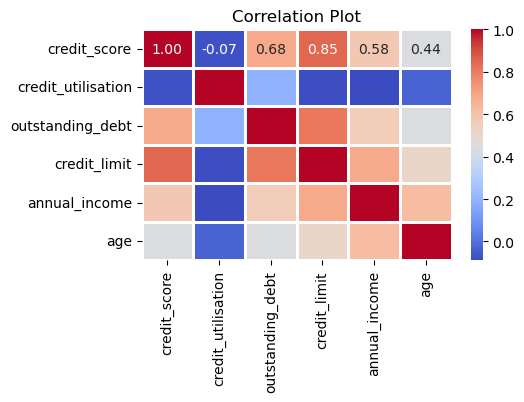

In [146]:
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.8)
plt.title('Correlation Plot')
plt.show()

## Explore Transaction

### Handle null values in Transaction

In [147]:
df_trans.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking


In [148]:
df_trans.isna().sum()

tran_id                0
cust_id                0
tran_date              0
tran_amount            0
platform            4941
product_category       0
payment_type           0
dtype: int64

In [149]:
df_trans['platform'].unique()

array(['Flipkart', 'Alibaba', 'Shopify', 'Amazon', 'Ebay', 'Meesho',
       'Cred', None], dtype=object)

In [150]:
df_trans[df_trans.platform.isna()]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
355,356,58,2023-01-01,237,None,Electronics,Net Banking
418,419,383,2023-01-01,338,None,Electronics,Credit Card
607,608,421,2023-01-01,700,None,Electronics,Phonepe
844,845,945,2023-01-01,493,None,Sports,Credit Card
912,913,384,2023-01-01,85,None,Fashion & Apparel,Phonepe
...,...,...,...,...,...,...,...
499579,499580,924,2023-09-05,31,None,Fashion & Apparel,Gpay
499646,499647,944,2023-09-05,58445,None,Fashion & Apparel,Phonepe
499725,499726,620,2023-09-05,15,None,Sports,Net Banking
499833,499834,616,2023-09-05,97,None,Fashion & Apparel,Credit Card


In [151]:
df_trans['platform'].value_counts()

platform
Amazon      151443
Flipkart    122660
Alibaba      73584
Meesho       73271
Shopify      39416
Cred         24741
Ebay          9944
Name: count, dtype: int64

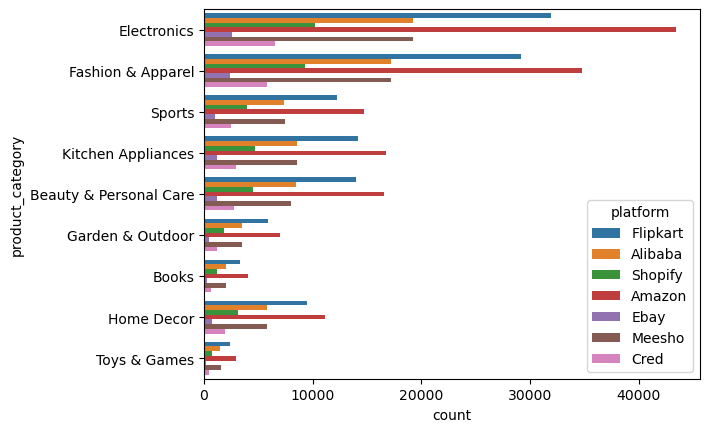

In [152]:
sns.countplot(y='product_category',hue='platform',data=df_trans)
plt.show()

In [153]:
df_trans.platform.mode()[0]

'Amazon'

In [154]:
df_trans['platform'].fillna(df_trans.platform.mode()[0],inplace=True)

In [155]:
df_trans.isnull().sum()

tran_id             0
cust_id             0
tran_date           0
tran_amount         0
platform            0
product_category    0
payment_type        0
dtype: int64

### Handling outliers in transaction

In [156]:
df_trans.describe()

,tran_id,cust_id,tran_amount
count,500000.000000,500000.000000,500000.00000
mean,250000.500000,501.400428,3225.20733
std,144337.711634,288.641924,13098.74276
min,1.000000,1.000000,0.00000
25%,125000.750000,252.000000,64.00000
50%,250000.500000,502.000000,141.00000
75%,375000.250000,752.000000,397.00000
max,500000.000000,1000.000000,69999.00000


#### from above we can infer that the tran_amount cant be zero

In [157]:
df_trans_zero=df_trans[df_trans['tran_amount']==0]
df_trans_zero

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
120,121,440,2023-01-01,0,Amazon,Electronics,Credit Card
141,142,839,2023-01-01,0,Amazon,Electronics,Credit Card
517,518,147,2023-01-01,0,Amazon,Electronics,Credit Card
533,534,891,2023-01-01,0,Amazon,Electronics,Credit Card
586,587,108,2023-01-01,0,Amazon,Electronics,Credit Card
...,...,...,...,...,...,...,...
499326,499327,695,2023-09-05,0,Amazon,Electronics,Credit Card
499494,499495,295,2023-09-05,0,Amazon,Electronics,Credit Card
499708,499709,141,2023-09-05,0,Amazon,Electronics,Credit Card
499928,499929,4,2023-09-05,0,Amazon,Electronics,Credit Card


In [158]:
df_trans_zero.shape

(4734, 7)

In [159]:
df_trans_zero[['platform','product_category','payment_type']].value_counts()

platform  product_category  payment_type
Amazon    Electronics       Credit Card     4734
Name: count, dtype: int64

#### As u can see above categories tran_amount is zero

In [160]:
df_trans_1 = df_trans[(df_trans.platform == 'Amazon') &(df_trans.product_category == 'Electronics')&(df_trans.payment_type == 'Credit Card')]
df_trans_1.shape

(15637, 7)

In [161]:
df_trans_1[df_trans_1.tran_amount > 0]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
109,110,887,2023-01-01,635,Amazon,Electronics,Credit Card
173,174,676,2023-01-01,60439,Amazon,Electronics,Credit Card
190,191,763,2023-01-01,697,Amazon,Electronics,Credit Card
263,264,528,2023-01-01,421,Amazon,Electronics,Credit Card
311,312,936,2023-01-01,537,Amazon,Electronics,Credit Card
...,...,...,...,...,...,...,...
499766,499767,723,2023-09-05,909,Amazon,Electronics,Credit Card
499793,499794,586,2023-09-05,304,Amazon,Electronics,Credit Card
499812,499813,688,2023-09-05,425,Amazon,Electronics,Credit Card
499860,499861,373,2023-09-05,480,Amazon,Electronics,Credit Card


In [162]:
median_to_replace = df_trans_1[df_trans_1.tran_amount > 0].tran_amount.median()
median_to_replace

554.0

In [163]:
df_trans['tran_amount'].replace(0,median_to_replace,inplace=True)

In [164]:
df_trans[df_trans.tran_amount==0]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type


In [165]:
df_trans.describe()

,tran_id,cust_id,tran_amount
count,500000.000000,500000.000000,500000.000000
mean,250000.500000,501.400428,3230.452602
std,144337.711634,288.641924,13097.561071
min,1.000000,1.000000,2.000000
25%,125000.750000,252.000000,66.000000
50%,250000.500000,502.000000,146.000000
75%,375000.250000,752.000000,413.000000
max,500000.000000,1000.000000,69999.000000


#### Now the trans_amount has a valid minimum value

In [166]:
df_trans[df_trans['tran_amount']>1000].describe()

,tran_id,cust_id,tran_amount
count,25000.000000,25000.000000,25000.000000
mean,249217.701480,501.874080,60036.367480
std,145331.383002,289.325492,5747.298494
min,27.000000,1.000000,50000.000000
25%,122650.750000,250.000000,55085.000000
50%,248097.500000,504.000000,60048.000000
75%,376694.750000,754.000000,64984.000000
max,499997.000000,1000.000000,69999.000000


In [167]:
Q1,Q3 = df_trans['tran_amount'].quantile([0.25,0.75])
IQR = Q3-Q1
lower = Q1 - 2 * IQR
upper = Q3 + 2 * IQR

lower, upper

(-628.0, 1107.0)

In [168]:
df_trans_outlier = df_trans[df_trans['tran_amount']>=upper]
df_trans_outlier

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
26,27,380,2023-01-01,61963,Shopify,Beauty & Personal Care,Credit Card
49,50,287,2023-01-01,57869,Amazon,Toys & Games,Gpay
94,95,770,2023-01-01,52881,Ebay,Kitchen Appliances,Credit Card
104,105,549,2023-01-01,58574,Flipkart,Fashion & Apparel,Gpay
113,114,790,2023-01-01,51669,Shopify,Kitchen Appliances,Credit Card
...,...,...,...,...,...,...,...
499742,499743,868,2023-09-05,55131,Meesho,Fashion & Apparel,Gpay
499888,499889,614,2023-09-05,59679,Meesho,Fashion & Apparel,Net Banking
499900,499901,811,2023-09-05,60184,Flipkart,Sports,Debit Card
499966,499967,662,2023-09-05,54678,Meesho,Sports,Gpay


In [169]:
df_trans_normal = df_trans[df_trans['tran_amount']<upper]
df_trans_normal

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking
...,...,...,...,...,...,...,...
499994,499995,679,2023-09-05,59,Ebay,Beauty & Personal Care,Gpay
499995,499996,791,2023-09-05,43,Amazon,Books,Phonepe
499997,499998,57,2023-09-05,224,Amazon,Garden & Outdoor,Phonepe
499998,499999,629,2023-09-05,538,Flipkart,Home Decor,Gpay


In [170]:
tran_mean_per_category = df_trans_normal.groupby("product_category")["tran_amount"].mean()
tran_mean_per_category

product_category
Beauty & Personal Care     92.167205
Books                      29.553515
Electronics               510.172685
Fashion & Apparel          64.553463
Garden & Outdoor          125.630277
Home Decor                302.487561
Kitchen Appliances        176.773288
Sports                    269.181631
Toys & Games               50.333298
Name: tran_amount, dtype: float64

In [171]:
df_trans.loc[df_trans_outlier.index]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
26,27,380,2023-01-01,61963,Shopify,Beauty & Personal Care,Credit Card
49,50,287,2023-01-01,57869,Amazon,Toys & Games,Gpay
94,95,770,2023-01-01,52881,Ebay,Kitchen Appliances,Credit Card
104,105,549,2023-01-01,58574,Flipkart,Fashion & Apparel,Gpay
113,114,790,2023-01-01,51669,Shopify,Kitchen Appliances,Credit Card
...,...,...,...,...,...,...,...
499742,499743,868,2023-09-05,55131,Meesho,Fashion & Apparel,Gpay
499888,499889,614,2023-09-05,59679,Meesho,Fashion & Apparel,Net Banking
499900,499901,811,2023-09-05,60184,Flipkart,Sports,Debit Card
499966,499967,662,2023-09-05,54678,Meesho,Sports,Gpay


In [172]:
df_trans.loc[df_trans_outlier.index,"tran_amount"]= df_trans_outlier['product_category'].map(tran_mean_per_category)

In [173]:
df_trans.loc[df_trans_outlier.index]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
26,27,380,2023-01-01,92.167205,Shopify,Beauty & Personal Care,Credit Card
49,50,287,2023-01-01,50.333298,Amazon,Toys & Games,Gpay
94,95,770,2023-01-01,176.773288,Ebay,Kitchen Appliances,Credit Card
104,105,549,2023-01-01,64.553463,Flipkart,Fashion & Apparel,Gpay
113,114,790,2023-01-01,176.773288,Shopify,Kitchen Appliances,Credit Card
...,...,...,...,...,...,...,...
499742,499743,868,2023-09-05,64.553463,Meesho,Fashion & Apparel,Gpay
499888,499889,614,2023-09-05,64.553463,Meesho,Fashion & Apparel,Net Banking
499900,499901,811,2023-09-05,269.181631,Flipkart,Sports,Debit Card
499966,499967,662,2023-09-05,269.181631,Meesho,Sports,Gpay


In [174]:
df_trans.describe()

,tran_id,cust_id,tran_amount
count,500000.000000,500000.000000,500000.000000
mean,250000.500000,501.400428,240.672998
std,144337.711634,288.641924,241.696597
min,1.000000,1.000000,2.000000
25%,125000.750000,252.000000,64.553463
50%,250000.500000,502.000000,133.000000
75%,375000.250000,752.000000,349.000000
max,500000.000000,1000.000000,999.000000


<Axes: xlabel='tran_amount', ylabel='Count'>

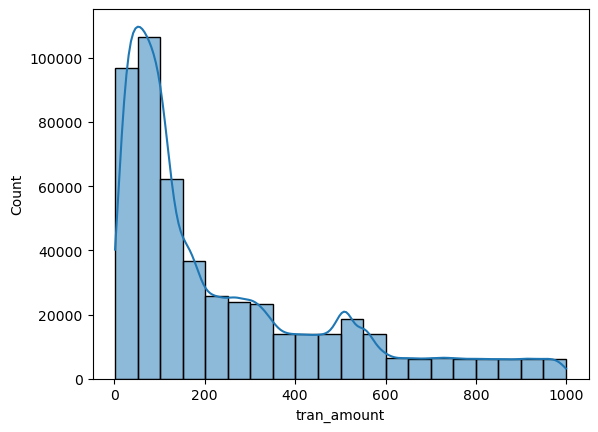

In [175]:
sns.histplot(x='tran_amount', data=df_trans, bins=20, kde=True)

### Distribution of payments across age groups

In [176]:
df_merged_1 = df_merged.merge(df_trans,on='cust_id',how='inner')
df_merged_1.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group,credit_score,...,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode,tran_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,0.0,40000.0,700-749,40000.0,1283,2023-01-01,30.0,Shopify,Fashion & Apparel,Net Banking
1,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,0.0,40000.0,700-749,40000.0,1382,2023-01-01,96.0,Amazon,Sports,Debit Card
2,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,0.0,40000.0,700-749,40000.0,1521,2023-01-01,86.0,Meesho,Garden & Outdoor,Gpay
3,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,0.0,40000.0,700-749,40000.0,1576,2023-01-01,149.0,Amazon,Beauty & Personal Care,Phonepe
4,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,0.0,40000.0,700-749,40000.0,1757,2023-01-01,37.0,Flipkart,Fashion & Apparel,Credit Card


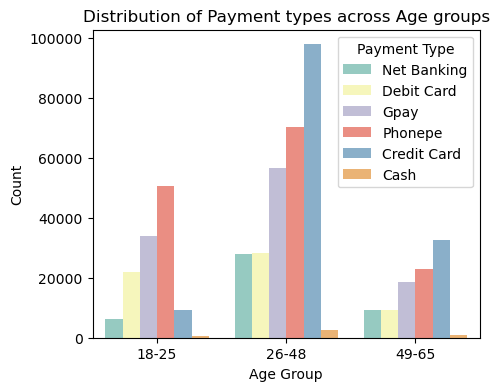

In [177]:
plt.figure(figsize=(5, 4))
sns.countplot(x='age_group', hue='payment_type', data=df_merged_1, palette='Set3')
plt.title('Distribution of Payment types across Age groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Payment Type', loc='upper right')

plt.show()

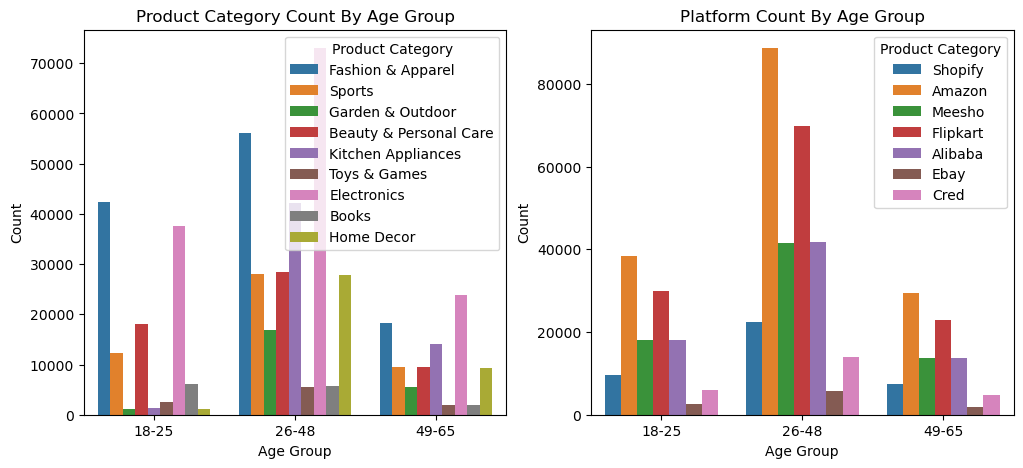

In [178]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

sns.countplot(x='age_group', hue="product_category", data=df_merged_1, ax=ax1)
ax1.set_title("Product Category Count By Age Group")
ax1.set_xlabel("Age Group")
ax1.set_ylabel("Count")
ax1.legend(title="Product Category", loc='upper right')

sns.countplot(x='age_group', hue="platform", data=df_merged_1, ax=ax2)
ax2.set_title("Platform Count By Age Group")
ax2.set_xlabel("Age Group")
ax2.set_ylabel("Count")
ax2.legend(title="Product Category", loc='upper right')

plt.show()


In [179]:
age_group_metrics = df_merged.groupby('age_group')[['annual_income', 'credit_limit', 'credit_score']].mean().reset_index()
age_group_metrics

,age_group,annual_income,credit_limit,credit_score
0,18-25,37091.235772,1130.081301,484.451220
1,26-48,145869.623457,20560.846561,597.569665
2,49-65,260165.925134,41699.197861,701.524064


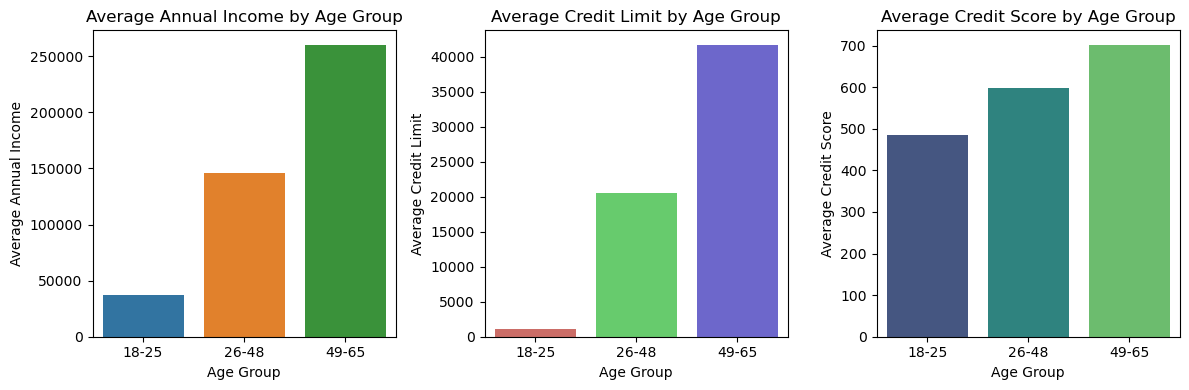

In [180]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Plot 1: Average annual income by age group
sns.barplot(x='age_group', y='annual_income', data=age_group_metrics, palette='tab10', ax=ax1)
ax1.set_title('Average Annual Income by Age Group')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Average Annual Income')
ax1.tick_params(axis='x', rotation=0)

# Plot 2: Average Max Credit Limit by Age Group
sns.barplot(x='age_group', y='credit_limit', data=age_group_metrics, palette='hls', ax=ax2)
ax2.set_title('Average Credit Limit by Age Group')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Average Credit Limit')
ax2.tick_params(axis='x', rotation=0)

# Plot 3: Average Credit Score by Age Group
sns.barplot(x='age_group', y='credit_score', data=age_group_metrics, palette='viridis', ax=ax3)
ax3.set_title('Average Credit Score by Age Group')
ax3.set_xlabel('Age Group')
ax3.set_ylabel('Average Credit Score')
ax3.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## After Campaign

In [181]:
import os
os.chdir('datasets')

In [182]:
import statsmodels.stats.api as sms
import statsmodels.api as sm
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns

In [183]:
camp = pd.read_csv('avg_transactions_after_campaign.csv')
camp.head()

,campaign_date,control_group_avg_tran,test_group_avg_tran
0,2023-09-10,259.83,277.32
1,2023-09-11,191.27,248.68
2,2023-09-12,212.41,286.61
3,2023-09-13,214.92,214.85
4,2023-09-14,158.55,344.08


In [184]:
# Calculate the required sample size for different effect sizes
alpha = 0.05
power = 0.8
effect_sizes=[0.1, 0.2, 0.3, 0.4, 0.5,1]

for effect_size in effect_sizes:
    sample_size= sms.tt_ind_solve_power(
        effect_size=effect_size, 
        alpha=alpha, 
        power=power, 
        ratio=1, 
        alternative='two-sided'
    )
    print(f"The no of smaples required is {int(sample_size)} for effect size {effect_size}")

The no of smaples required is 1570 for effect size 0.1
The no of smaples required is 393 for effect size 0.2
The no of smaples required is 175 for effect size 0.3
The no of smaples required is 99 for effect size 0.4
The no of smaples required is 63 for effect size 0.5
The no of smaples required is 16 for effect size 1


The campaign is launched for 100 customers, as determined by the effective size calculation and by considering budgeting costs, and will run campaign for a duration of 2 months

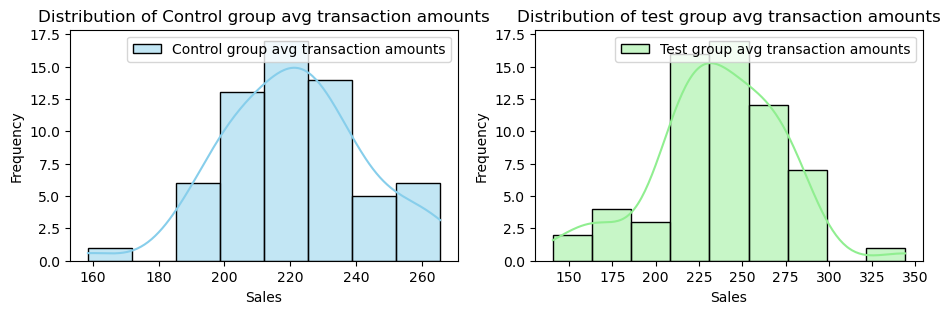

In [185]:
# Let's look at distributions of avg transactions amounts in both groups
# Create a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))

# Plot the distribution of Campaign A Sales
sns.histplot(camp['control_group_avg_tran'], kde=True, color='skyblue', label='Control group avg transaction amounts', ax=ax1)
ax1.set_xlabel('Sales')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Control group avg transaction amounts')
ax1.legend()

# Plot the distribution of Campaign B Sales
sns.histplot(camp['test_group_avg_tran'], kde=True, color='lightgreen', label='Test group avg transaction amounts', ax=ax2)
ax2.set_xlabel('Sales')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of test group avg transaction amounts')
ax2.legend()

# Show the plots
plt.show()

In [186]:
critical_z_value = st.norm.ppf(1 - alpha)
critical_z_value

1.6448536269514722

In [187]:
z_statistic,p_value = sm.stats.ztest(camp['test_group_avg_tran'], camp['control_group_avg_tran'],alternative = 'larger')
z_statistic,p_value 

(2.7482973745691135, 0.002995282462202502)

In [188]:
if z_statistic>critical_z_value or p_value < alpha:
   print("Reget the null hypothesis")
else:
    print("Reget the alternate hypothesis")

Reget the null hypothesis
